# Load Data


In [2]:
import numpy as np

from matplotlib import pyplot as plt
from time import time
from tqdm import tqdm
from scipy.sparse import csr_matrix, csc_matrix
from numba import jit

%matplotlib inline
plt.rcParams['figure.dpi'] = 140

from read_data import load_position_data

In [4]:
# Load Data

data_raw = np.load('data/all_data.npy') # Shape [STEPS, NUM_REL]
p_pos, c_pos = load_position_data('data/LOGFILE_unified_coordinates.txt')
NUM_SAMPLES, NUM_RELATIONS = data_raw.shape

print(data_raw.shape)

(65536, 2013)


# Downsampling

In [5]:
# Define signal freq. band

f_min, f_max = 2.5e6, 7e6 # [Hz]  Measured: 2_497_863, 6_999_206

# Sampling rate
f_samp = 100e6 # [Hz]

# Speed of sound
c_sound = 1_484_000.0 # [mm/s]

# Bandwidth
bwidth = f_max - f_min # [Hz]

# Sample time delta
dt_samp = 1/f_samp

In [6]:
idx1 = int(f_min/f_samp*NUM_SAMPLES) 
idx2 = int(f_max/f_samp*NUM_SAMPLES)
print({'index_min': idx1, 'index_max': idx2})

{'index_min': 1638, 'index_max': 4587}


In [7]:
data_ft = np.fft.fft(data_raw, axis=0)
data_sel = data_ft[idx1:idx2, :]
data = np.abs(np.fft.ifft(data_sel, axis=0))

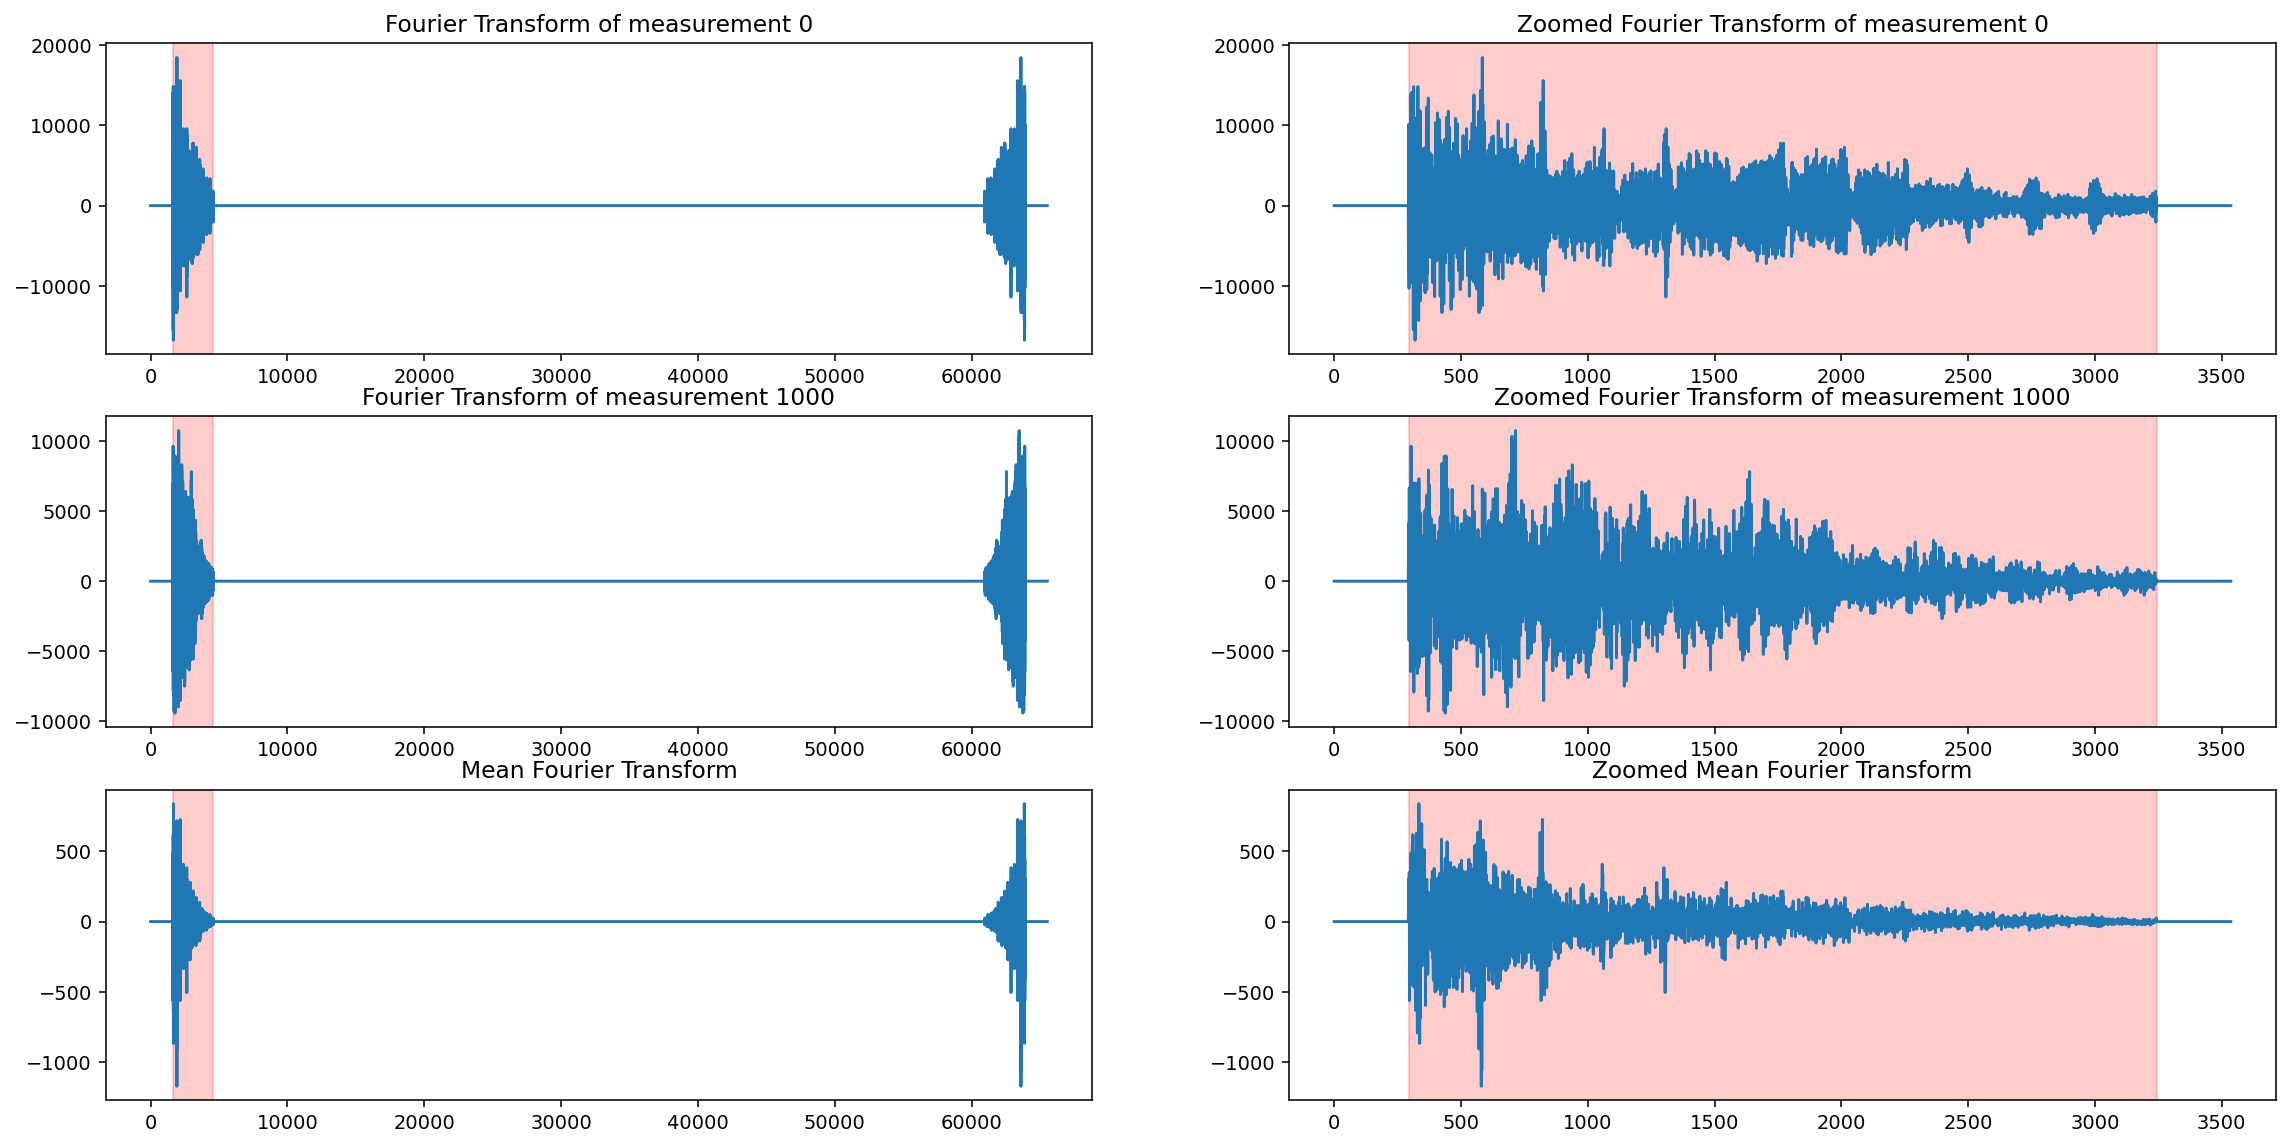

In [8]:
def plot_band_selection(samples = [0]):
    num_samples = len(samples)

    fig, axs = plt.subplots(num_samples+1, 2, figsize=[20,5*num_samples])

   

    for i, s in enumerate(samples):
        axs[i,0].plot(data_ft[:,s].real)
        axs[i,0].axvspan(idx1, idx2, color='red', alpha=0.2)
        axs[i,0].set_title(f'Fourier Transform of measurement {s}')

        h = int(0.1*(idx2 - idx1))
        axs[i,1].plot(data_ft[idx1-h:idx2+h, s].real)
        axs[i,1].axvspan(h, (idx2 - idx1)+h, color='red', alpha=0.2)
        axs[i,1].set_title(f'Zoomed Fourier Transform of measurement {s}')

    md = np.mean(data_ft.real, axis=1)
    axs[num_samples,0].plot(md)
    axs[num_samples,0].axvspan(idx1, idx2, color='red', alpha=0.2)
    axs[num_samples,0].set_title(f'Mean Fourier Transform')

    h = int(0.1*(idx2 - idx1))
    axs[num_samples,1].plot(md[idx1-h:idx2+h].real)
    axs[num_samples,1].axvspan(h, (idx2 - idx1)+h, color='red', alpha=0.2)
    axs[num_samples,1].set_title(f'Zoomed Mean Fourier Transform')



plot_band_selection([0, 1000])

(0.00027, 0.0003)

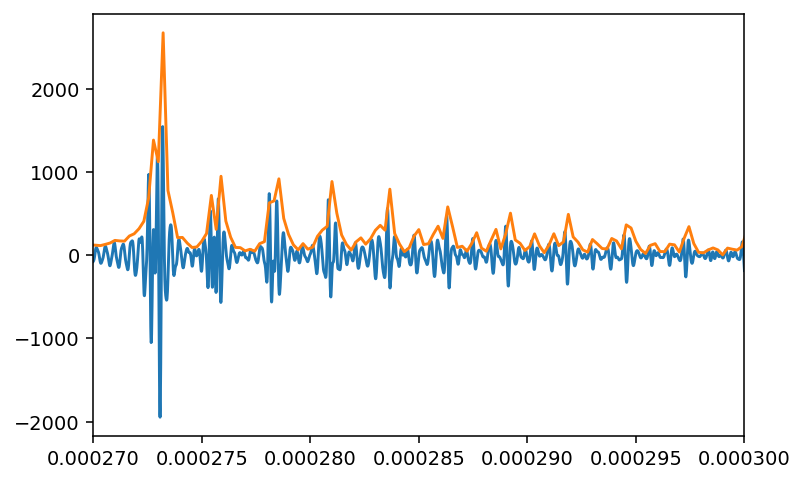

In [9]:
f_res = f_samp/NUM_SAMPLES * (data.shape[0])
dt = 1/f_res

plt.plot(np.linspace(0, data_raw.shape[0]*dt_samp, data_raw.shape[0]), 8*data_raw[:,0].real)
plt.plot(np.linspace(0, data.shape[0]*dt, data.shape[0]), abs(data[:,0]))
plt.xlim(0.00027, 0.0003)

In [10]:
# Define image plane
u, v, o = np.array([[40., 0, 0], [0., 0., -70.], [320., -110., 60.]])

# Define image plane resolution
res_u, res_v = 200, 350

In [11]:
u_scale = np.linspace(0, 1, res_u)[: , None, None]
v_scale = np.linspace(0, 1, res_v)[None, :, None]

grid = (u[None, None, :]*u_scale) + (v[None, None, :]*v_scale) + o[None, None, :]

In [12]:
piezo_filter   = lambda pos: np.allclose(pos, np.array([385.0, -110.0, 198.0]))
cMut_filter    = lambda pos: any(
    np.allclose(pos, np.array([k+311.1, -110.0, 198.0]))
    for k in range(0,61)
    for l in range(-5, 7, 5)
)

selected_p = np.apply_along_axis(piezo_filter, 0, p_pos)
selected_c = np.apply_along_axis(cMut_filter, 0, c_pos)
selected = np.logical_and(selected_p, selected_c)
NUM_RELATION = np.sum(selected)

selected_idxs, = selected.nonzero()


NUM_RELATION

61

In [13]:
dr = dt * c_sound

def image_rx_tx(rx_pos, tx_pos, start, stop, rel):
    D_rx = np.linalg.norm(grid - rx_pos, axis= 2)
    D_tx = np.linalg.norm(grid - tx_pos, axis= 2)
    
    D_total = D_rx+D_tx


    Mt = np.zeros([res_u*res_v, stop-start])

    for i in range(start, stop):
        ff = np.ravel( ((D_total) < (i+1)*dr) * ((D_total) > i*dr))
        rsq = np.ravel(D_total**2)

        # Mt computes the approx. inverse
        Mt[:, i-start] = rsq*ff


    p = np.dot(Mt, data[rel,start:stop])
    r = p.reshape([res_u, res_v])
    return r

dr

0.3297911970159376

In [14]:
import math

# Only use samples where ellipsoide goes through the image plane 
# therefore compute minimal and maximal time define interval of interest on samples
distances = np.linalg.norm(p_pos[None,None,:,selected]-grid[:,:,:,None], axis=2) + \
            np.linalg.norm(c_pos[None,None,:,selected]-grid[:,:,:,None], axis=2)

min_dist = np.min(distances)
max_dist = np.max(distances)

lower_sample_idx = math.floor(((min_dist / c_sound)) * f_res) # inclusive
upper_sample_idx = math.ceil(((max_dist / c_sound)) * f_res)+1 # not inclusive

NUM_SAMPLES = upper_sample_idx - lower_sample_idx

NUM_SAMPLES

469

Selected signal parts are shown below. We want to emphasize, that the mean signal looks similar to the single relation data. This hints that there is no big information gain from including more sensors (due to the big difference between aperture size and distance to the ROI)

Text(0.5, 1.0, 'Relation 676 (first selected)')

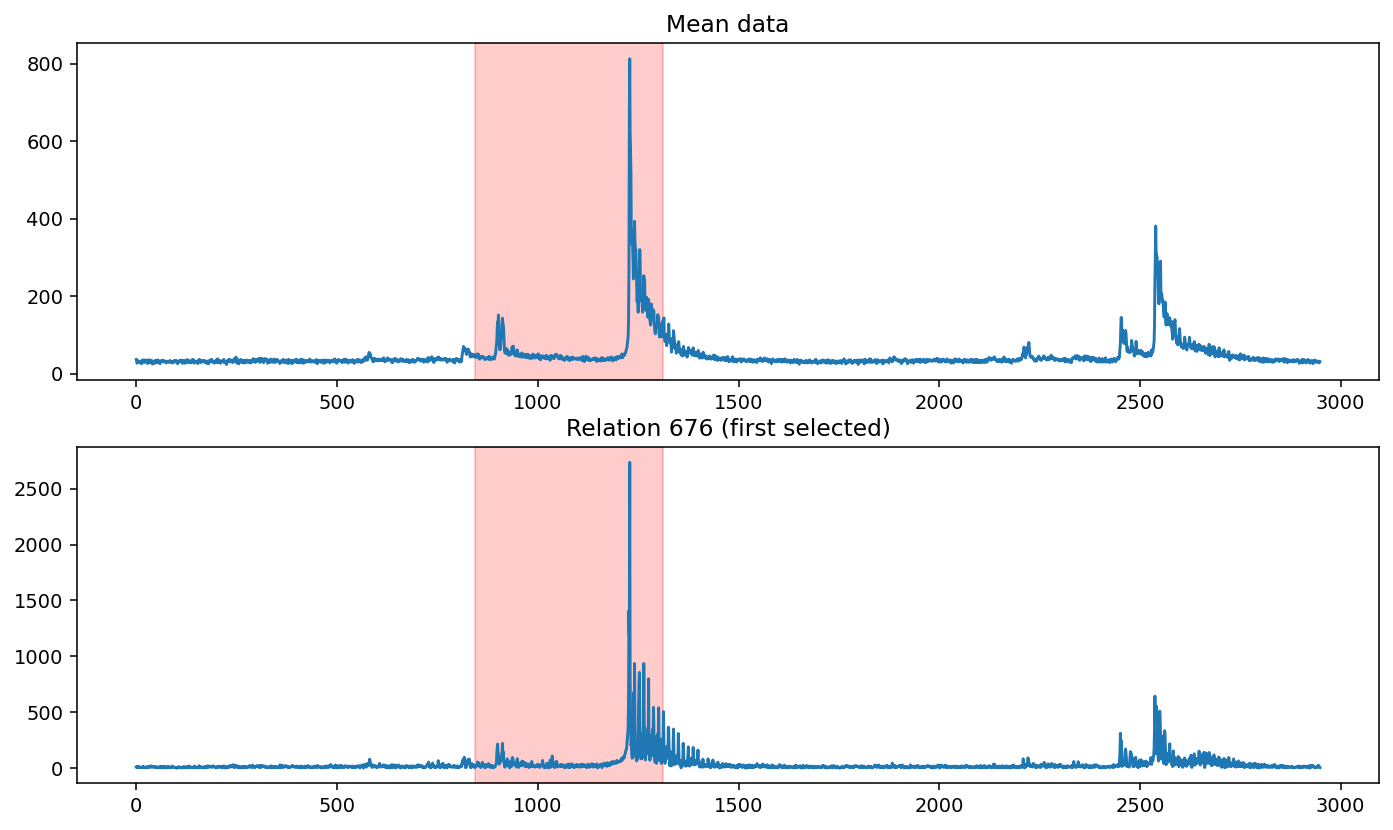

In [15]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,7))

ax1.plot(np.mean(data[:,selected], axis=1))
ax1.axvspan(lower_sample_idx, upper_sample_idx, color='red', alpha=0.2)
ax1.set_title('Mean data')

s = selected_idxs[0]
ax2.plot(data[:,s])
ax2.axvspan(lower_sample_idx, upper_sample_idx, color='red', alpha=0.2)
ax2.set_title(f'Relation {s} (first selected)')

In [16]:
ri = np.zeros([res_u, res_v])
for i in tqdm(selected_idxs):
        rii = image_rx_tx(c_pos[None,None,:,i], p_pos[None,None,:,i], lower_sample_idx, upper_sample_idx, i)
        ri += rii

100%|██████████| 61/61 [00:42<00:00,  1.44it/s]


The figure below has a poor lateral resolution

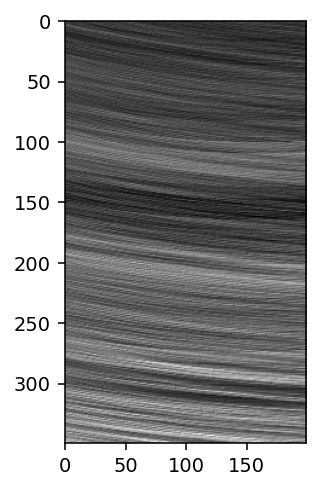

In [17]:
plt.imshow(ri.T, cmap='gray')